In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint

# 1

In [3]:
weekly_cases_df = pd.read_csv("HW4_all_weeks.csv")

In [16]:
stats.t.interval(0.95, df=len(exponential_growth_df)-2)

(-2.131449545559323, 2.131449545559323)

(0.37990354752962646, 0.45812794326430123) 0.01835004630948173


<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/var/folders/y_/2bb9t7kj1ql5pvbqf85sggh40000gs/T/ipykernel_95954/1744643891.py:10: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(exponential_growth_df['Week'], np.polyval(coefficients, exponential_growth_df['Week']), color='red', label=f'Linear Fit, m={coefficients[0]:.2f}$\pm${pm:.2f}')
/var/folders/y_/2bb9t7kj1ql5pvbqf85sggh40000gs/T/ipykernel_95954/1744643891.py:12: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log$(New Cases)')


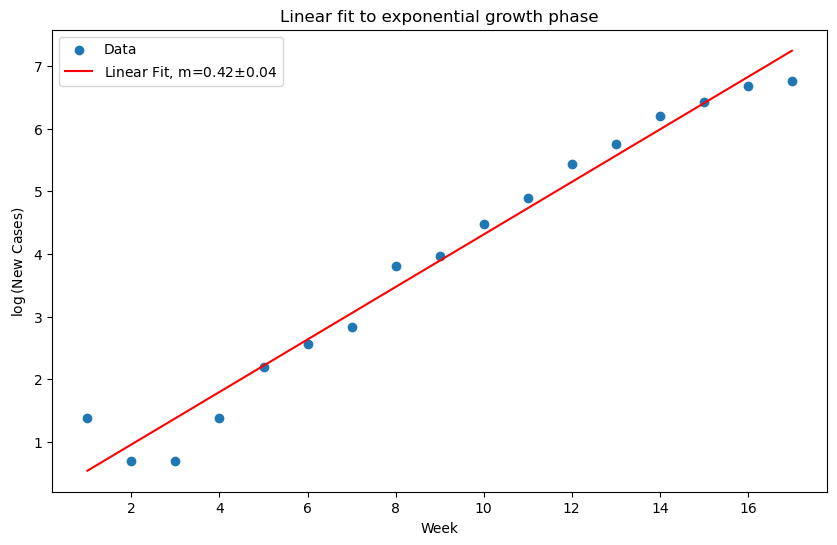

In [17]:
max_week = np.where(weekly_cases_df['New Cases'] == weekly_cases_df['New Cases'].max())[0][0]
exponential_growth_df = weekly_cases_df.iloc[:max_week + 1]
# linear fit
coefficients, cov = np.polyfit(exponential_growth_df['Week'], np.log(exponential_growth_df['New Cases']), 1, cov=True)
se_slope = np.sqrt(cov[0][0])
ci = stats.t.interval(0.95, df=len(exponential_growth_df)-2, loc=coefficients[0], scale=se_slope)
pm = (se_slope * stats.t.ppf((1 + 0.95) / 2., len(exponential_growth_df) - 2))
plt.figure(figsize=(10, 6))
plt.scatter(exponential_growth_df['Week'], np.log(exponential_growth_df['New Cases']), marker='o', label='Data')
plt.plot(exponential_growth_df['Week'], np.polyval(coefficients, exponential_growth_df['Week']), color='red', label=f'Linear Fit, m={coefficients[0]:.2f}$\pm${pm:.2f}')
plt.xlabel('Week')
plt.ylabel('$\log$(New Cases)')
plt.title('Linear fit to exponential growth phase')
plt.legend()
print(ci, se_slope)
plt.savefig("plots/1a_linear_fit.png")

In [20]:
# CI for R0
mu = 1/ 100
gamma = 1 / 2
(1 + ci[0] / (gamma + mu), 1 + ci[1] / (gamma + mu))

(1.7449089167247578, 1.898290084831963)

In [27]:
# R0 from prevalence
i_eq = 7 / 1000
def r0_from_prevalence(i_eq, mu, gamma):
    return 1 / (1 - i_eq * (gamma / mu + 1))
R0 = r0_from_prevalence(i_eq, mu, gamma)
ci_prevalence = proportion_confint(count=7, nobs=1000, alpha=0.05, method='beta')
print(ci_prevalence)
ci_prevalence = (r0_from_prevalence(ci_prevalence[0], mu, gamma), r0_from_prevalence(ci_prevalence[1], mu, gamma))
print(f"Prevalence method estimates: R0={R0:.3f}, CI=({ci_prevalence[0]:.3f}, {ci_prevalence[1]:.3f})")

(0.002818858759620524, 0.014369194978918634)
Prevalence method estimates: R0=1.555, CI=(1.168, 3.743)


In [26]:
# R0 from seroprevalence
sero = 517 / 1000
def r0_from_seroprevalence(sero):
    return 1 / (1 - sero)
R0_sero = r0_from_seroprevalence(sero)
ci_sero = proportion_confint(count=517, nobs=1000, alpha=0.05, method='beta')
ci_sero = (r0_from_seroprevalence(ci_sero[0]), r0_from_seroprevalence(ci_sero[1]))
print(f"Seroprevalence method estimates: R0={R0_sero:.3f}, CI=({ci_sero[0]:.3f}, {ci_sero[1]:.3f})")

Seroprevalence method estimates: R0=2.070, CI=(1.944, 2.214)


# 2

In [28]:
phi = 0.39
se = 0.9
sp = 0.98
(phi - (1 - sp)) / (se + sp - 1)

0.4204545454545455

In [30]:
ci = proportion_confint(39, 100, alpha=0.05, method='beta')
ci_adjusted = ((ci[0] - (1 - sp)) / (se + sp - 1), (ci[1] - (1 - sp)) / (se + sp - 1))
print(f"Adjusted prevalence CI=({ci_adjusted[0]:.3f}, {ci_adjusted[1]:.3f})")

Adjusted prevalence CI=(0.311, 0.537)


In [31]:
def prevalence_correction(phi, se, sp):
    return (phi - (1 - sp)) / (se + sp - 1)
phi2 = 18 / 50
theta2 = prevalence_correction(phi2, se, sp)
ci2 = proportion_confint(18, 50, alpha=0.05, method='beta')
ci2_adjusted = (prevalence_correction(ci2[0], se, sp), prevalence_correction(ci2[1], se, sp))
print(f"Adjusted prevalence from Burt: theta={theta2:.3f} CI=({ci2_adjusted[0]:.3f}, {ci2_adjusted[1]:.3f})")

Adjusted prevalence from Burt: theta=0.386 CI=(0.238, 0.555)


In [32]:
ci2

(0.2291570668205873, 0.5080686477143989)

In [33]:
# once more with pooled data
phi_pooled = (39 + 18) / (100 + 50)
theta_pooled = prevalence_correction(phi_pooled, se, sp)
ci_pooled = proportion_confint(39 + 18, 100 + 50, alpha=0.05, method='beta')
ci_pooled_adjusted = (prevalence_correction(ci_pooled[0], se, sp), prevalence_correction(ci_pooled[1], se, sp))
print(f"Pooled adjusted prevalence: theta={theta_pooled:.3f} CI=({ci_pooled_adjusted[0]:.3f}, {ci_pooled_adjusted[1]:.3f})")

Pooled adjusted prevalence: theta=0.409 CI=(0.321, 0.503)


In [35]:
# compute PPV from pooled prevalence estimate
ppv = (se * theta_pooled) / (se * theta_pooled + (1 - sp) * (1 - theta_pooled))
print(f"Pooled PPV={ppv:.3f}")

Pooled PPV=0.969


# 3

In [44]:
data_df = pd.read_csv('HW4_Q3_data-1.csv', header=None).rename(columns={0: 'assay'})
neg_df = pd.read_csv('HW4_Q3_neg-1.csv', header=None).rename(columns={0: 'assay'})
pos_df = pd.read_csv('HW4_Q3_pos-1.csv', header=None).rename(columns={0: 'assay'})

In [45]:
data_df

,assay
0,5.051466
1,5.733980
2,5.882876
3,6.348639
4,6.567216
...,...
295,36.635155
296,37.120295
297,39.460292
298,41.108045


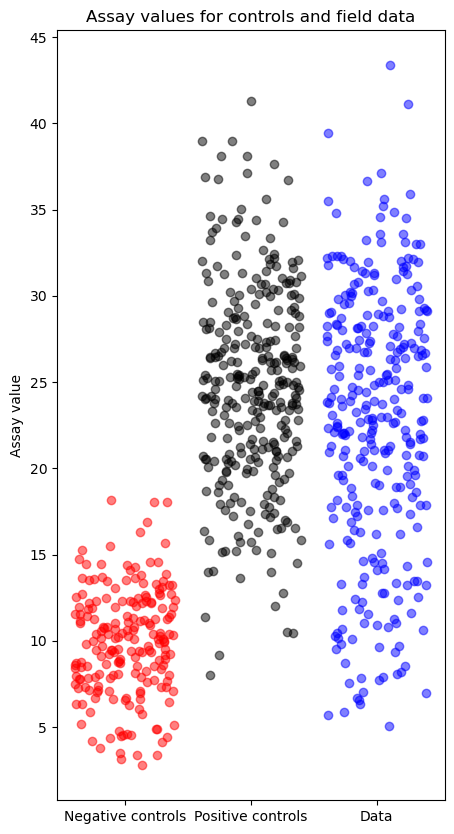

In [69]:
plt.figure(figsize=(5, 10))
plt.scatter(np.random.uniform(0, 0.4, size=len(neg_df.assay)), neg_df.assay, color='r', alpha=0.5)
plt.scatter(np.random.uniform(0.5, 0.9, size=len(pos_df.assay)), pos_df.assay, color='k', alpha=0.5)
plt.scatter(np.random.uniform(1, 1.4, size=len(data_df.assay)), data_df.assay, color='b', alpha=0.5)
plt.xticks([0.2, 0.7, 1.2], ['Negative controls', 'Positive controls', 'Data'])
plt.ylabel('Assay value')
plt.title('Assay values for controls and field data')
plt.savefig('plots/3a_assay_values.png')

In [70]:
def cutoff_phi(c):
    field_assays = data_df.assay
    return (field_assays >= c).mean()

def cutoff_se(c):
    tp = (pos_df.assay >= c).sum()
    fn = (pos_df.assay < c).sum()
    return tp / (tp + fn)

def cutoff_sp(c):
    tn = (neg_df.assay < c).sum()
    fp = (neg_df.assay >= c).sum()
    return tn / (tn + fp)

def cutoff_theta(c):
    phi_hat = cutoff_phi(c)
    se_hat = cutoff_se(c)
    sp_hat = cutoff_sp(c)
    return (phi_hat - (1 - sp_hat)) / (se_hat + sp_hat - 1)

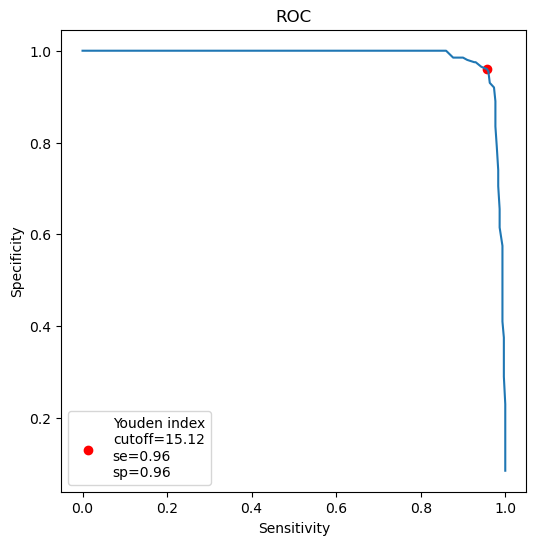

In [75]:
cutoffs = np.linspace(data_df.assay.min(), data_df.assay.max(), 100)
sp = [cutoff_sp(c) for c in cutoffs]
se = [cutoff_se(c) for c in cutoffs]
j = [se[i] + sp[i] - 1 for i in range(len(cutoffs))]
youden_index = np.argmax(j)
plt.figure(figsize=(6, 6))
plt.plot(se, sp)
plt.scatter(se[youden_index], sp[youden_index], color='red', label=f'Youden index\ncutoff={cutoffs[youden_index]:.2f}\nse={se[youden_index]:.2f}\nsp={sp[youden_index]:.2f}')
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title('ROC')
plt.legend()
plt.savefig('plots/3c_roc.png')

/var/folders/y_/2bb9t7kj1ql5pvbqf85sggh40000gs/T/ipykernel_95954/3417642672.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  return (phi_hat - (1 - sp_hat)) / (se_hat + sp_hat - 1)


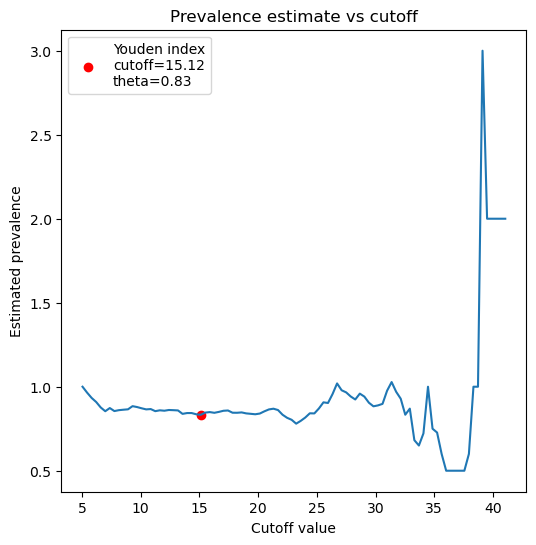

In [76]:
plt.figure(figsize=(6, 6))
thetas = [cutoff_theta(c) for c in cutoffs]
plt.plot(cutoffs, thetas)
plt.scatter(cutoffs[youden_index], thetas[youden_index], color='red', label=f'Youden index\ncutoff={cutoffs[youden_index]:.2f}\ntheta={thetas[youden_index]:.2f}')
plt.xlabel("Cutoff value")
plt.ylabel("Estimated prevalence")
plt.title('Prevalence estimate vs cutoff')
plt.legend()
plt.savefig('plots/3d_prevalence_vs_cutoff.png')

In [77]:
thetas

[1.0,
 0.9649122807017547,
 0.9333333333333319,
 0.9090909090909081,
 0.8765432098765429,
 0.8541666666666674,
 0.8730158730158732,
 0.855072463768116,
 0.86046511627907,
 0.8631578947368425,
 0.8654708520179374,
 0.8842975206611569,
 0.8790035587188613,
 0.871621621621622,
 0.8651026392961875,
 0.8670360110803325,
 0.8545454545454546,
 0.8595641646489105,
 0.8571428571428573,
 0.8614718614718615,
 0.8603696098562629,
 0.8588709677419355,
 0.8384615384615385,
 0.8432835820895521,
 0.8432835820895521,
 0.8360655737704917,
 0.8327272727272729,
 0.8458715596330276,
 0.8489871086556169,
 0.8447319778188539,
 0.8501872659176029,
 0.8568738229755178,
 0.858508604206501,
 0.8452611218568663,
 0.8449612403100777,
 0.8470588235294116,
 0.8412698412698414,
 0.8387096774193549,
 0.8360655737704917,
 0.8403361344537813,
 0.853448275862069,
 0.8648648648648649,
 0.8691588785046729,
 0.8612440191387558,
 0.8333333333333331,
 0.8150000000000002,
 0.8031088082901555,
 0.7801047120418847,
 0.7967032967

In [80]:
cutoffs[np.argmin(thetas)], thetas[np.argmin(thetas)]

(36.01729688207192, 0.49999999999999845)